## Deep Learning(Transfer Learning) Method: Fine-tuning pre-trained BERT models for our task

In [1]:
# Google Colab
# Install huggingface pytorch version transformers packages
from IPython.display import clear_output
!pip install transformers
clear_output()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from collections import defaultdict
from IPython.display import clear_output

import random
random.seed(42)

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(42)

np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Test GPU
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

1.8.1+cu101
True
Tesla K80
1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/MyDrive/FinalYearProject')

In [6]:
train_preprocessed_data = pd.DataFrame(pd.read_csv('./Dataset_preprocessed/train_preprocessed.tsv', sep='\t'))
valid_preprocessed_data = pd.DataFrame(pd.read_csv('./Dataset_preprocessed/valid_preprocessed.tsv', sep='\t'))
test_preprocessed_data = pd.DataFrame(pd.read_csv('./Dataset_preprocessed/test_preprocessed.tsv', sep='\t'))

In [7]:
#Select different pre-train bert models by using https://huggingface.co/transformers/pretrained_models.html
class configurations:
  MODEL = 'bert-large-cased'
  TOKENIZER = AutoTokenizer.from_pretrained(MODEL)
  MAX_LEN = 64
  EPOCHS = 4
  BATCH_SIZE = 32
  DEVICE = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
  clear_output()

### Preparing the Dataset

In [8]:
def encode_data(tweets, tokenizer, max_len, labels):

  token_ids = tokenizer.encode(tweets, add_special_tokens=True)
  mask = [1] * len(token_ids)

  padding = max_len - len(token_ids)

  if padding>=0:
    token_ids = token_ids + ([0] * padding)
    mask = mask + ([0] * padding)
  else:
    token_ids = token_ids[0:max_len]
    mask = mask[0:max_len]

  assert len(token_ids)==max_len
  assert len(mask)==max_len

  return {'tweets':tweets,
          'input_ids':token_ids,
          'attention_mask':mask,
          'labels':labels}

In [9]:
class CovidTweetsDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = configurations.TOKENIZER
        self.max_len = configurations.MAX_LEN

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):

      encoding = encode_data(
            self.tweets[item],
            self.tokenizer,
            self.max_len,
            self.labels[item],
        )

      return {
          'tweets': encoding['tweets'],
          'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
          'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
          'labels': torch.tensor(encoding['labels'], dtype=torch.long),
      }


In [10]:
def setup_seed(seed = 42):
  """
  Fix seed for reproducibility
  """
  # python RNG
  import random
  random.seed(seed)

  # pytorch RNGs
  import torch
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

  # numpy RNG
  import numpy as np
  np.random.seed(seed)

In [11]:
setup_seed()

train_dataset = CovidTweetsDataset(
    tweets = train_preprocessed_data.Text_pre_processed.values,
    labels = train_preprocessed_data.Label.values,)

valid_dataset = CovidTweetsDataset(
    tweets = valid_preprocessed_data.Text_pre_processed.values,
    labels = valid_preprocessed_data.Label.values,
    )

test_dataset = CovidTweetsDataset(
      tweets = test_preprocessed_data.Text_pre_processed.values,
      labels = test_preprocessed_data.Label.values,
  )

train_sampler = RandomSampler(train_dataset)
validation_sampler = SequentialSampler(valid_dataset)
test_sampler = SequentialSampler(test_dataset)

train_dataset_loader = DataLoader(train_dataset,
                                  sampler=train_sampler,
                                  batch_size=configurations.BATCH_SIZE,
                                  num_workers=2)

valid_dataset_loader = DataLoader(valid_dataset,
                                  sampler=validation_sampler,
                                  batch_size=configurations.BATCH_SIZE,
                                  num_workers=2)

test_dataset_loader = DataLoader(test_dataset,
                                  sampler=test_sampler,
                                  batch_size=configurations.BATCH_SIZE,
                                  num_workers=2)

In [12]:
train_dataset[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  9018,  1473, 10484,  1121,  1884, 15789, 27608,  1107,  1103,
          1244,  2325,  1110,  1208,   144, 16941, 13821,  9637,  1190,  1860,
          2870,  4507,  4318,  5288,  4747,  3865,  5776,  4323,  2270, 18732,
         20660, 11607, 10069,  1993,  5486,  1571, 16660, 24482,  2044, 12855,
          1372, 16183, 16660, 11866,  2044,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'labels': tensor(1),
 'tweets': 'Official death toll from coronavirus in the United Kingdom is now GREATER than Germany  Poland  Switzerland  Austria  Portugal  Greece  Sweden  Finland  Norway  Ireland COMBINED UK 675 Million 233 dead

### Setup the Model

In [13]:
class BertLinearClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BertLinearClassifier, self).__init__()
    self.bert_model = AutoModel.from_pretrained(configurations.MODEL)
    self.drop = nn.Dropout(p=0.2)
    self.out = nn.Linear(self.bert_model.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert_model(input_ids=input_ids, 
                                       attention_mask=attention_mask,
                                       return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [14]:
BertLinearModel = BertLinearClassifier(2)
BertLinearModel = BertLinearModel.to(configurations.DEVICE)

In [15]:
# We choose Cross Entropy Loss for our task. 
loss_function = nn.CrossEntropyLoss().to(configurations.DEVICE)

# We use original BERT recommend settings here.
param_optimizer = list(BertLinearModel.named_parameters())
no_decay = ['bias', 'LayerNorm.weight','LayerNorm.bias']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

# We don't want any warmup step.
total_steps = len(train_dataset_loader) * configurations.EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)



### Training and evaluation process

In [16]:
def train_epoch(model, data_loader, loss_function, optimizer, device, scheduler, n_examples):
  
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    model.zero_grad()
    
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, predictions = torch.max(outputs, dim=1)

    loss = loss_function(outputs, labels)

    correct_predictions += torch.sum(predictions == labels)
    losses.append(loss.item())

    optimizer.zero_grad()

    loss.backward()

    # Update parameters
    optimizer.step()
    # Update the learning rate.
    scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
def eval_model(model, data_loader, loss_function, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      # Load all the input data
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(input_ids=input_ids, 
                      attention_mask=attention_mask)
      
      _, predictions = torch.max(outputs, dim=1)

      loss = loss_function(outputs, labels)

      correct_predictions += torch.sum(predictions == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:
#From https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Start training and testing

In [ ]:
import time

history = defaultdict(list)
best_accuracy = 0

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=2, path='./BERT_Models/best_BERT_large_cased_state.bin',verbose=True)

setup_seed()

for epoch in range(configurations.EPOCHS):

  print(f'Epoch {epoch + 1}/{configurations.EPOCHS}')
  print('-' * 10)
  
  start_time = time.time()

  train_acc, train_loss = train_epoch(BertLinearModel,
                                      train_dataset_loader,
                                      loss_function,
                                      optimizer,
                                      configurations.DEVICE,
                                      scheduler,
                                      len(train_preprocessed_data))
  end_time = time.time()

  print(f'Train loss: {train_loss}, Train Accuracy: {train_acc}, Train Time: {end_time-start_time}')
  
  start_time = time.time()
  val_acc, val_loss = eval_model(BertLinearModel, 
                                 valid_dataset_loader,
                                 loss_function,
                                 configurations.DEVICE,
                                 len(valid_preprocessed_data))
  end_time = time.time()
  print(f'Valid loss: {val_loss}, Valid Accuracy: {val_acc}, Validation Time: {end_time-start_time}')
  print('\n')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  # early_stopping needs the validation loss to check if it has decresed, 
  # and if it has, it will make a checkpoint of the current model
  early_stopping(val_loss, BertLinearModel)
      
  if early_stopping.early_stop:
      print("Early stopping")
      break

Epoch 1/4
----------
Train loss: 0.2853143325067002, Train Accuracy: 0.8728571428571429, Train Time: 268.09235763549805
Valid loss: 0.29295940179144964, Valid Accuracy: 0.88, Validation Time: 12.833033323287964


Validation loss decreased (inf --> 0.292959).  Saving model ...
Epoch 2/4
----------
Train loss: 0.09221774011374065, Train Accuracy: 0.9690000000000001, Train Time: 272.2948157787323
Valid loss: 0.3774025526945479, Valid Accuracy: 0.885, Validation Time: 12.755007028579712


EarlyStopping counter: 1 out of 2
Epoch 3/4
----------
Train loss: 0.030712394076760977, Train Accuracy: 0.9901428571428572, Train Time: 271.34831070899963
Valid loss: 0.4619085178419482, Valid Accuracy: 0.891, Validation Time: 12.81023645401001


EarlyStopping counter: 2 out of 2
Early stopping


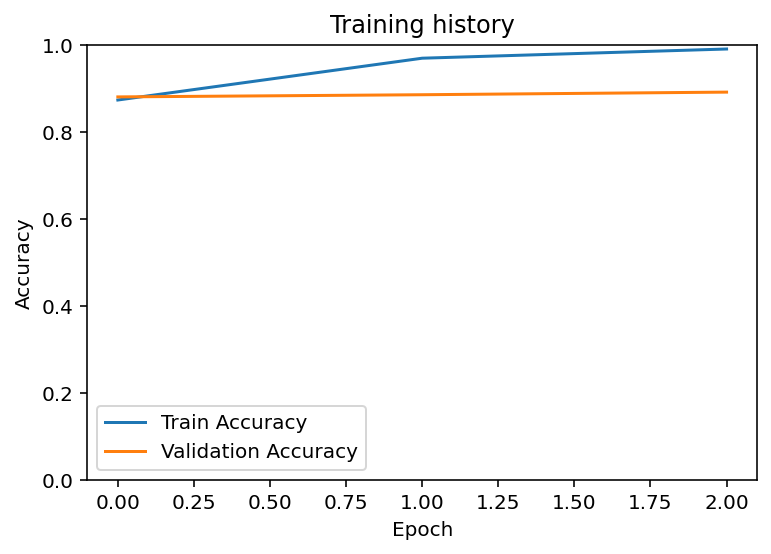

In [ ]:
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

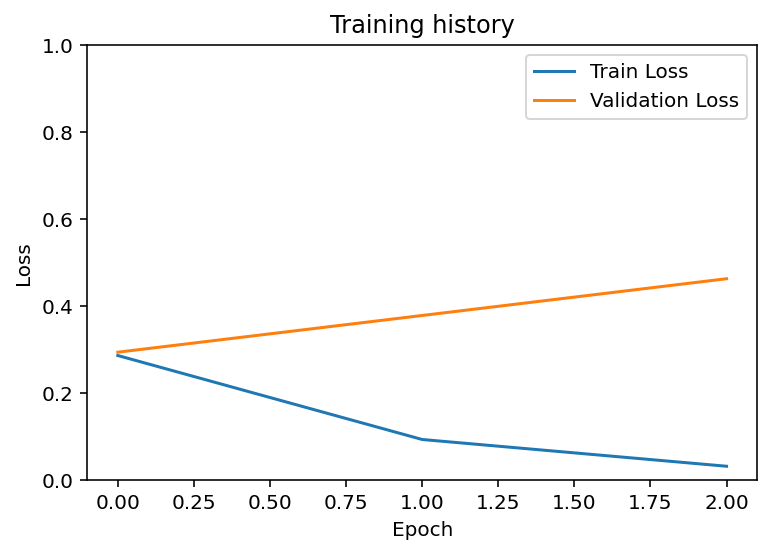

In [ ]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [19]:
BertLinearModel = BertLinearClassifier(2)
BertLinearModel.load_state_dict(torch.load('./BERT_Models/best_BERT_large_cased_state.bin'))
BertLinearModel = BertLinearModel.to(configurations.DEVICE)

In [20]:
test_accuracy, _ = eval_model(BertLinearModel,
                              test_dataset_loader,
                              loss_function,
                              configurations.DEVICE,
                              len(test_preprocessed_data))

test_accuracy.item()

0.8705

### Analysis of results

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  tweets = []
  predictions = []
  prediction_probabilitys = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      
      tweet = d["tweets"]
      input_ids = d["input_ids"].to(configurations.DEVICE)
      attention_mask = d["attention_mask"].to(configurations.DEVICE)
      labels = d["labels"].to(configurations.DEVICE)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probabilitys = F.softmax(outputs, dim=1)

      tweets.extend(tweet)
      predictions.extend(preds)
      prediction_probabilitys.extend(probabilitys)
      real_values.extend(labels)
  # Concatenates a sequence of tensors along a new dimension.
  predictions = torch.stack(predictions).cpu()
  prediction_probabilitys = torch.stack(prediction_probabilitys).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweets, predictions, prediction_probabilitys, real_values

In [ ]:
y_tweets, y_predictions, y_prediction_probabilitys, y_test = get_predictions(BertLinearModel, test_dataset_loader)

In [ ]:
print(accuracy_score(y_test, y_predictions))
print(classification_report(y_test, y_predictions, target_names=['Uninformative', 'Informative']))

0.8705
               precision    recall  f1-score   support

Uninformative       0.87      0.89      0.88      1056
  Informative       0.87      0.85      0.86       944

     accuracy                           0.87      2000
    macro avg       0.87      0.87      0.87      2000
 weighted avg       0.87      0.87      0.87      2000



In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Label')
  plt.xlabel('Predict Label');

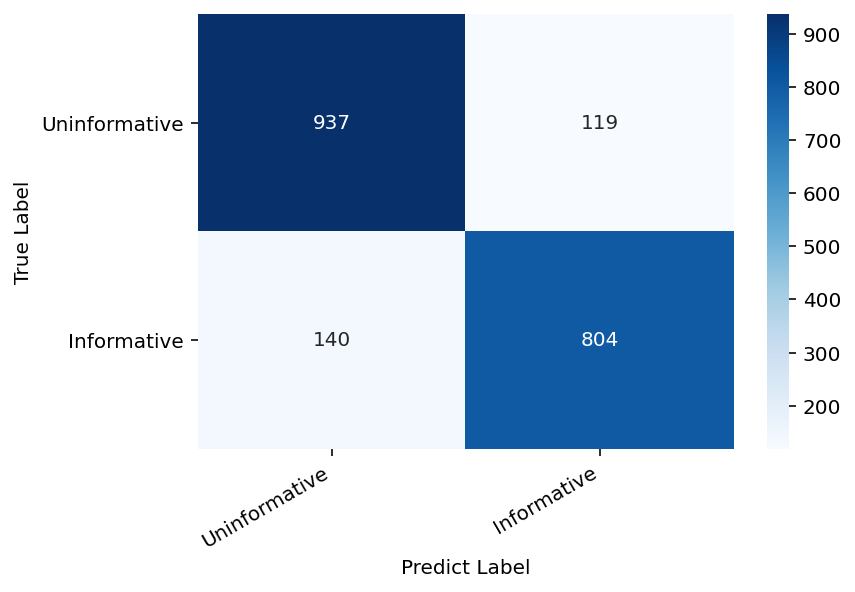

In [ ]:
confusionMatrix = confusion_matrix(y_test,y_predictions)
df_confusionMatrix = pd.DataFrame(confusionMatrix, index=['Uninformative', 'Informative'], columns=['Uninformative', 'Informative'])
show_confusion_matrix(df_confusionMatrix)

# Semi-Supervised Learning with unlabeled data

### Preparing the unlabeled dataset

In [ ]:
unlabeled_test_with_noise_preprocessed = pd.DataFrame(pd.read_csv('./Dataset_preprocessed/unlabeled_test_with_noise_preprocessed.tsv', sep='\t'))

In [ ]:
def encode_unlabeled_data(tweets, tokenizer, max_len):

  token_ids = tokenizer.encode(tweets, add_special_tokens=True)
  mask = [1] * len(token_ids)

  padding = max_len - len(token_ids)

  if padding>=0:
    token_ids = token_ids + ([0] * padding)
    mask = mask + ([0] * padding)
  else:
    token_ids = token_ids[0:max_len]
    mask = mask[0:max_len]

  assert len(token_ids)==max_len
  assert len(mask)==max_len

  return {'tweets':tweets,
          'input_ids':token_ids,
          'attention_mask':mask,}

In [ ]:
class CovidUnlabeledTweetsDataset(Dataset):
    def __init__(self, tweets):
        self.tweets = tweets
        self.tokenizer = configurations.TOKENIZER
        self.max_len = configurations.MAX_LEN

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):

      encoding = encode_unlabeled_data(
            self.tweets[item],
            self.tokenizer,
            self.max_len,
        )

      return {
          'tweets': encoding['tweets'],
          'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
          'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
      }


In [ ]:
unlabeled_dataset = CovidUnlabeledTweetsDataset(
    tweets = unlabeled_test_with_noise_preprocessed.Text_pre_processed.values)

unlabeled_sampler = SequentialSampler(unlabeled_dataset)

unlabeled_dataset_loader = DataLoader(unlabeled_dataset,
                                      sampler=unlabeled_sampler,
                                      batch_size=configurations.BATCH_SIZE,
                                      num_workers=2)

### Pseudo-Labelling

In [ ]:
def get_unlabeled_predictions(model, data_loader):
  model = model.eval()

  tweets = []
  predictions = []
  prediction_probabilitys = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      
      tweet = d["tweets"]
      input_ids = d["input_ids"].to(configurations.DEVICE)
      attention_mask = d["attention_mask"].to(configurations.DEVICE)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probabilitys = F.softmax(outputs, dim=1)

      tweets.extend(tweet)
      predictions.extend(preds)
      prediction_probabilitys.extend(probabilitys)

  # Concatenates a sequence of tensors along a new dimension.
  predictions = torch.stack(predictions).cpu()
  prediction_probabilitys = torch.stack(prediction_probabilitys).cpu()

  return tweets, predictions, prediction_probabilitys

In [ ]:
BertLinearModel = BertLinearClassifier(2)
BertLinearModel.load_state_dict(torch.load('./BERT_Models/best_BERT_large_cased_state.bin'))
BertLinearModel = BertLinearModel.to(configurations.DEVICE)

In [ ]:
unlabeled_tweets, unlabeled_predictions, unlabeled_prediction_probabilitys = get_unlabeled_predictions(BertLinearModel, unlabeled_dataset_loader)

In [ ]:
probabilitys, _= torch.max(unlabeled_prediction_probabilitys, dim=1)
probabilitys

tensor([0.9965, 0.9860, 0.5912,  ..., 0.9004, 0.9959, 0.9938])

In [ ]:
pseudoLabel_data = {'Label': unlabeled_predictions, 'Text_pre_processed': unlabeled_tweets,'Probability': probabilitys}
pseudoLabel_df = pd.DataFrame(data=pseudoLabel_data)
#pseudoLabel_df

In [ ]:
threshold = 0.98
trust_pseudoLabel_df = pseudoLabel_df[pseudoLabel_df['Probability'] >= threshold]
trust_pseudoLabel_df.shape

(8068, 3)

In [ ]:
semi_supervised_data = pd.concat([train_preprocessed_data[['Label','Text_pre_processed']], trust_pseudoLabel_df[['Label','Text_pre_processed']]], axis=0, ignore_index=True)
semi_supervised_data.shape

(15068, 2)

In [ ]:
def count_informative_and_uninformative_tweets(df):
    informative_count = 0
    uninformative_count = 0

    for label in df['Label']:
        if label == 1:
            informative_count += 1
        else:
            uninformative_count += 1

    return informative_count, uninformative_count

train_informative_count, train_uninformative_count = count_informative_and_uninformative_tweets(semi_supervised_data)
print('There are {} informative tweets and {} uninformative tweets in the Training Set!'.format(train_informative_count, train_uninformative_count))

There are 8759 informative tweets and 6309 uninformative tweets in the Training Set!


In [ ]:
#https://elitedatascience.com/imbalanced-classes
from sklearn.utils import resample

df_minority = semi_supervised_data[semi_supervised_data['Label'] == 0]
df_majority = semi_supervised_data[semi_supervised_data['Label'] == 1]

df_minority_upsample = resample(df_minority, replace=True, n_samples=df_majority['Label'].count(), random_state=42)

balanced_semi_supervised_data = pd.concat([df_minority_upsample, df_majority], axis=0, ignore_index=True)

train_informative_count, train_uninformative_count = count_informative_and_uninformative_tweets(balanced_semi_supervised_data)
print('There are {} informative tweets and {} uninformative tweets in the Training Set!'.format(train_informative_count, train_uninformative_count))

#balanced_semi_supervised_data

There are 8759 informative tweets and 8759 uninformative tweets in the Training Set!


In [ ]:
setup_seed()
semi_train_dataset = CovidTweetsDataset(
    tweets = balanced_semi_supervised_data.Text_pre_processed.values,
    labels = balanced_semi_supervised_data.Label.values)

semi_train_sampler = RandomSampler(semi_train_dataset)

semi_train_dataset_loader = DataLoader(semi_train_dataset,
                                       sampler=semi_train_sampler,
                                       batch_size=configurations.BATCH_SIZE,
                                       num_workers=2)

### Setup Semi Model

In [ ]:
class SemiBertLinearClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SemiBertLinearClassifier, self).__init__()
    self.bert_model = AutoModel.from_pretrained(configurations.MODEL)
    self.drop = nn.Dropout(p=0.2)
    self.out = nn.Linear(self.bert_model.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert_model(input_ids=input_ids, 
                                       attention_mask=attention_mask,
                                       return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
SemiBertLinearModel = SemiBertLinearClassifier(2)
SemiBertLinearModel = SemiBertLinearModel.to(configurations.DEVICE)

In [ ]:
# We choose Cross Entropy Loss for our task. 
loss_function = nn.CrossEntropyLoss().to(configurations.DEVICE)

# We use original BERT recommend settings here.
param_optimizer = list(SemiBertLinearModel.named_parameters())
no_decay = ['bias', 'LayerNorm.weight','LayerNorm.bias']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

# We don't want any warmup step.
total_steps = len(semi_train_dataset_loader) * configurations.EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)


### Training and Testing

In [ ]:
import time

history = defaultdict(list)
best_accuracy = 0

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=2, path='./BERT_Semi_Models/best_semi_BERT_large_cased_state.bin',verbose=True)

setup_seed()

for epoch in range(configurations.EPOCHS):

  print(f'Epoch {epoch + 1}/{configurations.EPOCHS}')
  print('-' * 10)
  
  start_time = time.time()

  train_acc, train_loss = train_epoch(SemiBertLinearModel,
                                      semi_train_dataset_loader,
                                      loss_function,
                                      optimizer,
                                      configurations.DEVICE,
                                      scheduler,
                                      len(balanced_semi_supervised_data))
  end_time = time.time()

  print(f'Train loss: {train_loss}, Train Accuracy: {train_acc}, Train Time: {end_time-start_time}')
  
  start_time = time.time()
  val_acc, val_loss = eval_model(SemiBertLinearModel, 
                                 valid_dataset_loader,
                                 loss_function,
                                 configurations.DEVICE,
                                 len(valid_preprocessed_data))
  end_time = time.time()
  print(f'Valid loss: {val_loss}, Valid Accuracy: {val_acc}, Validation Time: {end_time-start_time}')
  print('\n')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)


  # early_stopping needs the validation loss to check if it has decresed, 
  # and if it has, it will make a checkpoint of the current model
  early_stopping(val_loss, SemiBertLinearModel)
      
  if early_stopping.early_stop:
      print("Early stopping")
      break

Epoch 1/4
----------
Train loss: 0.13674520214987293, Train Accuracy: 0.9479392624728851, Train Time: 675.10031914711
Valid loss: 0.32209856930421665, Valid Accuracy: 0.891, Validation Time: 12.734748601913452


Validation loss decreased (inf --> 0.322099).  Saving model ...
Epoch 2/4
----------
Train loss: 0.032157277542121374, Train Accuracy: 0.9913232104121475, Train Time: 674.610114812851
Valid loss: 0.4392073035123758, Valid Accuracy: 0.892, Validation Time: 12.795783281326294


EarlyStopping counter: 1 out of 2
Epoch 3/4
----------
Train loss: 0.01428448420935047, Train Accuracy: 0.9962895307683526, Train Time: 673.695830821991
Valid loss: 0.5419865421717986, Valid Accuracy: 0.895, Validation Time: 12.754804611206055


EarlyStopping counter: 2 out of 2
Early stopping


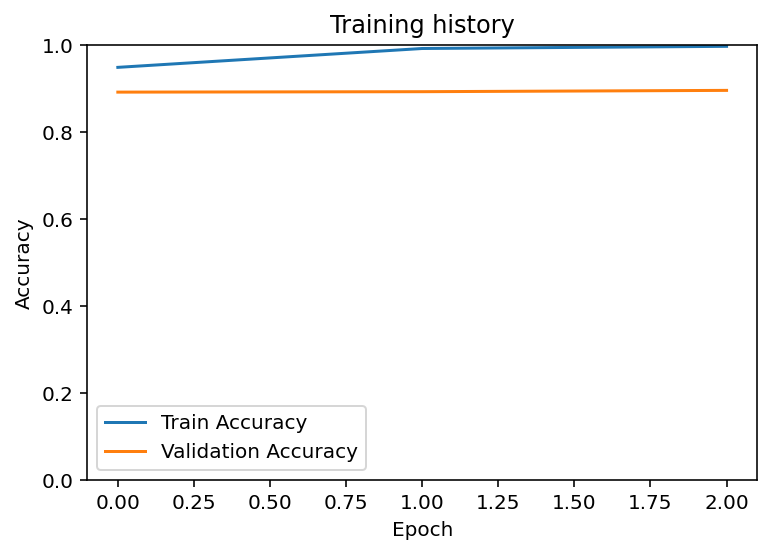

In [ ]:
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

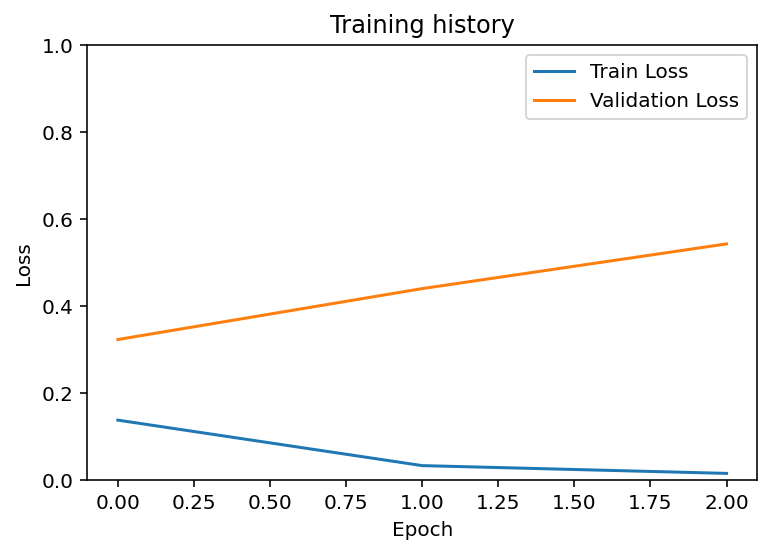

In [ ]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
SemiBertLinearModel = SemiBertLinearClassifier(2)
SemiBertLinearModel.load_state_dict(torch.load('./BERT_Semi_Models/best_semi_BERT_large_cased_state.bin'))
SemiBertLinearModel = SemiBertLinearModel.to(configurations.DEVICE)

In [ ]:
test_accuracy, _ = eval_model(SemiBertLinearModel,
                              test_dataset_loader,
                              loss_function,
                              configurations.DEVICE,
                              len(test_preprocessed_data))

test_accuracy.item()

0.882

### Analysis of results

In [ ]:
y_tweets, y_predictions, y_prediction_probabilitys, y_test = get_predictions(SemiBertLinearModel, test_dataset_loader)

In [ ]:
print(accuracy_score(y_test, y_predictions))
print(classification_report(y_test, y_predictions, target_names=['Uninformative', 'Informative']))

0.882
               precision    recall  f1-score   support

Uninformative       0.89      0.88      0.89      1056
  Informative       0.87      0.88      0.88       944

     accuracy                           0.88      2000
    macro avg       0.88      0.88      0.88      2000
 weighted avg       0.88      0.88      0.88      2000



In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Label')
  plt.xlabel('Predict Label');

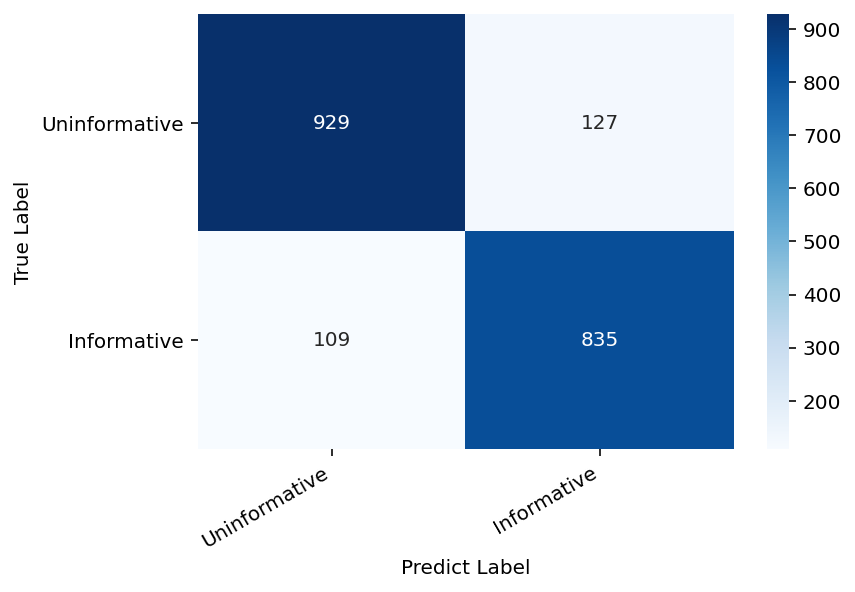

In [ ]:
confusionMatrix = confusion_matrix(y_test,y_predictions)
df_confusionMatrix = pd.DataFrame(confusionMatrix, index=['Uninformative', 'Informative'], columns=['Uninformative', 'Informative'])
show_confusion_matrix(df_confusionMatrix)